In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import numpy as np

In [15]:
df = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")

In [3]:
df.head()

,time,tmax,tmin,rhum,wfday,pm25,GEOID,smoke_pm,heatday,coldday,...,hw,hp,hwp,hwps,hs,hws,ws,hs5,hws5,ws5
0,2006-01-01,16.850000,11.850000,99.300003,False,3.784,6071010032,0.0,False,False,...,False,False,False,0,False,False,False,False,False,False
1,2006-01-02,18.749994,8.850000,100.000000,False,6.400,6071010032,0.0,False,False,...,False,False,False,0,False,False,False,False,False,False
2,2006-01-03,22.950006,7.950006,88.900002,False,11.912,6071010032,0.0,False,False,...,False,False,False,0,False,False,False,False,False,False
3,2006-01-04,28.749994,12.850000,55.500000,False,6.392,6071010032,0.0,True,False,...,False,False,False,1,False,False,False,False,False,False
4,2006-01-05,28.850000,12.649988,22.500000,False,10.996,6071010032,0.0,True,False,...,False,False,False,1,False,False,False,False,False,False


In [4]:
df.columns

Index(['time', 'tmax', 'tmin', 'rhum', 'wfday', 'pm25', 'GEOID', 'smoke_pm',
       'heatday', 'coldday', 'polluted', 'smoke_pm_non_zero',
       'smoke_pm_gt_five', 'hw', 'hp', 'hwp', 'hwps', 'hs', 'hws', 'ws', 'hs5',
       'hws5', 'ws5'],
      dtype='object')

In [5]:
def merge_shapefile(df):
    df = df.reset_index()
    df["year"] = df["time"].dt.year
    gdf = gpd.read_file("data/esri/FIPSMapping.gdb")
    gdf["FIPS_1"] = gdf.FIPS_1.astype(int)
    temp = gdf.merge(df, left_on="FIPS_1", right_on="GEOID")
    return temp

## Mean annual wildfire PM2.5 concentration.

In [6]:
df = df[['time','GEOID','smoke_pm']]

In [8]:
df = df.groupby("GEOID")[
        [
            "time",
            "smoke_pm"
        ]
    ].resample("Y", on="time").mean()

In [9]:
temp = merge_shapefile(df)

In [11]:
df = temp

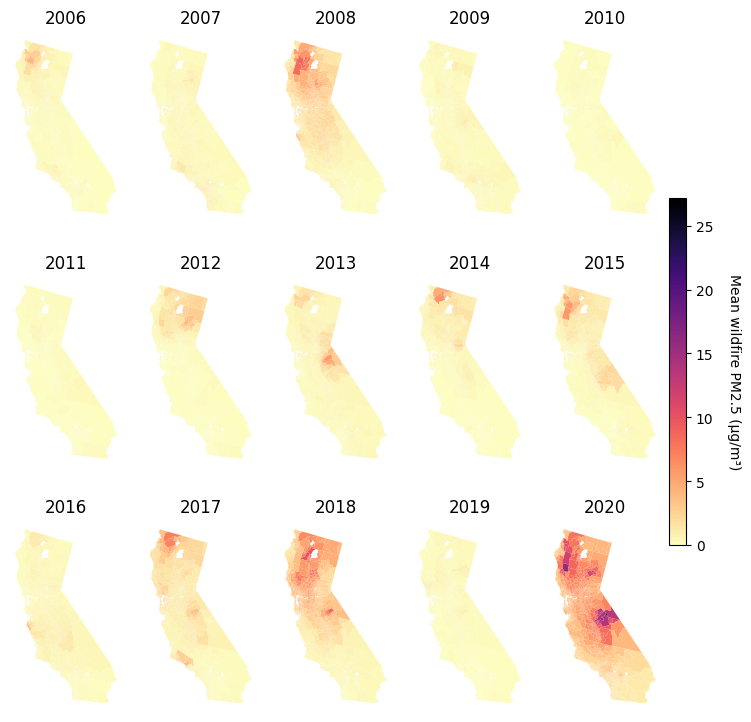

In [14]:
fig, axs = plt.subplots(3, 5, figsize=(10, 9)) 
axs = axs.flatten()  # Flatten the array of Axes objects into a single dimension

# Creating a common colorbar
vmin = df['smoke_pm'].min()
vmax = df['smoke_pm'].max()
cmap = 'magma_r'

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

for i, year in enumerate(df['year'].unique()):
    data = df[df['year'] == year]  # Filter data for the specific year
    ax = axs[i]
    data.plot(column='smoke_pm', ax=ax, cmap=cmap,
              vmin=vmin, vmax=vmax, legend=False)
    ax.set_title(f'{year}')
    ax.set_axis_off()

cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', pad=0.01, shrink=0.5)
cbar.set_label('Mean wildfire PM2.5 (μg/m\u00b3)', rotation=270, labelpad=20)

#plt.tight_layout()
plt.savefig("figures/mean_wildfire_PM25_per_year.png")
plt.show()

## Number of days with non-zero wildfire PM2.5 concentrations

In [16]:
df_non_zero = df[df['smoke_pm'] != 0]
df_non_zero = df_non_zero.groupby("GEOID")[
        [
            "time",
            "smoke_pm"
        ]
    ].resample("Y", on="time").count()

In [17]:
df_non_zero.head() 

smoke_pm
GEOID      time                
6001400100 2006-12-31        20
           2007-12-31        13
           2008-12-31        47
           2009-12-31        12
           2010-12-31        11

In [18]:
df = merge_shapefile(df_non_zero)

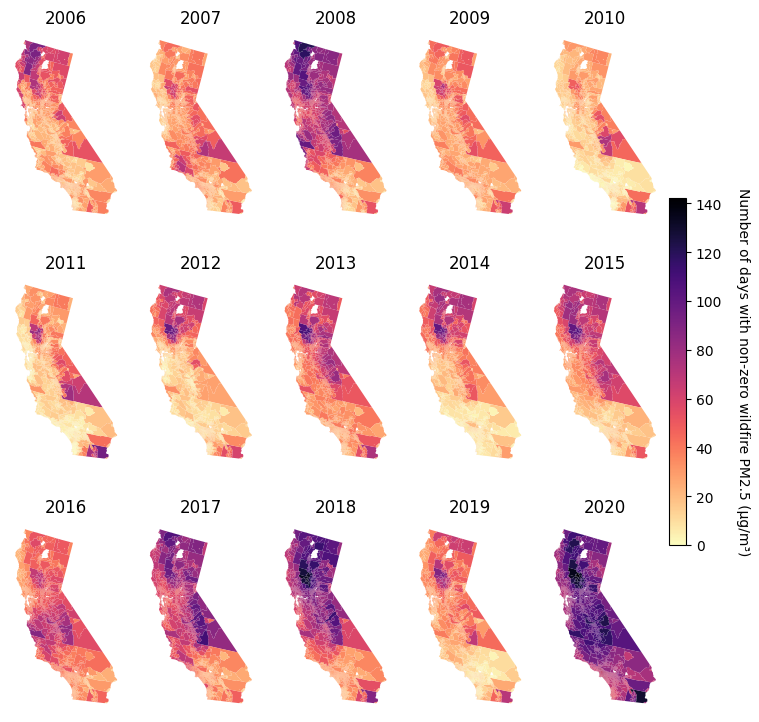

In [21]:
fig, axs = plt.subplots(3, 5, figsize=(10, 9))  # Create a 3x5 grid of subplots
axs = axs.flatten()  # Flatten the array of Axes objects into a single dimension

# Creating a common colorbar
vmin = df['smoke_pm'].min()
vmax = df['smoke_pm'].max()
cmap = 'magma_r'

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

for i, year in enumerate(df['year'].unique()):
    data = df[df['year'] == year]  # Filter data for the specific year
    ax = axs[i]
    data.plot(column='smoke_pm', ax=ax, cmap=cmap,
              vmin=vmin, vmax=vmax, legend=False)
    ax.set_title(f'{year}')
    ax.set_axis_off()

# Add a colorbar to the figure
#fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', pad=0.01)
# Add a colorbar to the figure
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', pad=0.01, shrink=0.5)
cbar.set_label('Number of days with non-zero wildfire PM2.5 (μg/m\u00b3)', rotation=270, labelpad=20)


#plt.tight_layout()
plt.savefig("figures/days_with_nonzero_wildfire_PM25_per_year.png")
plt.show()

(A) Number of weeks with average wildfire PM2.5 > 5 μg/m3; 
(C) Mean daily wildfire PM2.5 exposure during the peak week; 
(D) Number of smoke wavesa; 